In [1]:
# ==========================================
# CELL 1: ENVIRONMENT SETUP & IMPORTS
# ==========================================

# Uncomment if running in Colab or a clean environment:
# !pip install rdkit xgboost optuna selfies pandas numpy scikit-learn matplotlib seaborn shap umap-learn

import os
import sys
import random
import warnings
import time

# Data Science & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Optimization
import xgboost as xgb
import optuna
import joblib
import shap
import umap
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Chemoinformatics
import selfies as sf
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, QED, DataStructs
from rdkit import RDLogger

# --- Global Configuration ---

# Suppress standard warnings and RDKit logs for cleaner output
warnings.filterwarnings("ignore")
RDLogger.DisableLog('rdApp.*')

# Set publication-quality plotting style
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")

# Ensure reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print(f"Environment ready. Random seed set to {SEED}.")

Environment ready. Random seed set to 42.


In [2]:
# ==========================================
# CELL 2: DATA ACQUISITION & SCAFFOLD GENERATION
# ==========================================

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Configuration
DATA_URL = "https://raw.githubusercontent.com/postera-ai/COVID_moonshot_submissions/refs/heads/master/covid_submissions_all_info.csv"
FP_RADIUS = 2
FP_BITS = 2048

def fetch_data(url):
    print(f"Downloading data from {url}...")
    try:
        df = pd.read_csv(url)
        print("Download successful.")
        return df
    except Exception as e:
        print(f"Error downloading data: {e}")
        raise

def validate_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def get_morgan_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return np.array(fp)

def generate_scaffold(smiles):
    """Generates the Bemis-Murcko scaffold for validation groups."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        try:
            core = MurckoScaffold.GetScaffoldForMol(mol)
            return Chem.MolToSmiles(core)
        except:
            return "Generic"
    return "Invalid"

# --- Main Execution ---

# 1. Load Data
df = fetch_data(DATA_URL)

# 2. Filter and Clean
df_clean = df[['SMILES', 'f_avg_IC50']].dropna().copy()
df_clean = df_clean[df_clean['f_avg_IC50'] > 0]

# 3. Calculate pIC50
df_clean['pIC50'] = -np.log10(df_clean['f_avg_IC50'] * 1e-6)
df_clean = df_clean[(df_clean['pIC50'] > 2) & (df_clean['pIC50'] < 13)]

# 4. Validate Structures
df_clean = df_clean[df_clean['SMILES'].apply(validate_smiles)]

# 5. ASSIGN SCAFFOLDS (Kluczowe dla publikacji Q1)
print("Generating chemical scaffolds for validation groups...")
df_clean['scaffold'] = df_clean['SMILES'].apply(generate_scaffold)
print(f"Data ready. Molecules: {len(df_clean)}. Unique Scaffolds: {df_clean['scaffold'].nunique()}")

# 6. Feature Engineering
print("Generating Morgan Fingerprints...")
X = np.array([get_morgan_fingerprint(s, FP_RADIUS, FP_BITS) for s in df_clean['SMILES']])
y = df_clean['pIC50'].values
groups = df_clean['scaffold'].values # To posłuży do GroupKFold

print("Pre-processing complete.")

Download successful.
Generating chemical scaffolds for validation groups...
Data ready. Molecules: 2260. Unique Scaffolds: 1106
Generating Morgan Fingerprints...
Pre-processing complete.


In [3]:
# ==========================================
# CELL 3: MODEL TRAINING (XGBOOST ORACLE)
# ==========================================

import xgboost as xgb
import optuna
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

# --- Configuration ---
N_TRIALS = 30
N_FOLDS = 5

def xgb_objective(trial):
    """
    Optuna objective function for hyperparameter tuning.
    Uses GroupKFold to ensure scaffold-based validation (rigorous evaluation).
    """
    params = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': SEED,
        # Hyperparameter search space
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    model = xgb.XGBRegressor(**params)
    
    # Validation Strategy: GroupKFold based on Chemical Scaffolds
    # This prevents the model from seeing structurally similar molecules in train/test
    gkf = GroupKFold(n_splits=N_FOLDS)
    scores = []
    
    # Note: X, y, and groups are accessed from the global scope (Cell 2 output)
    for train_idx, val_idx in gkf.split(X, y, groups=groups):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(rmse)
    
    return np.mean(scores)

# --- Optimization Execution ---

print("--- STARTING HYPERPARAMETER OPTIMIZATION (XGBoost) ---")
# Suppress excessive logging for cleaner output
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(xgb_objective, n_trials=N_TRIALS) 

print(f"Optimization Complete.")
print(f"   - Best RMSE (Scaffold CV): {study_xgb.best_value:.4f}")
print(f"   - Best Params: {study_xgb.best_params}")

# --- Final Model Training ---

print("Training final Oracle model on full dataset...")
best_params = study_xgb.best_params
best_params.update({
    'n_jobs': -1, 
    'objective': 'reg:squarederror',
    'random_state': SEED,
    'verbosity': 0
})

oracle_model = xgb.XGBRegressor(**best_params)
oracle_model.fit(X, y)

print("✅ XGBoost Oracle successfully trained and ready for inference.")

--- STARTING HYPERPARAMETER OPTIMIZATION (XGBoost) ---
Optimization Complete.
   - Best RMSE (Scaffold CV): 0.6871
   - Best Params: {'n_estimators': 143, 'max_depth': 4, 'learning_rate': 0.07558968937028464, 'subsample': 0.8898386781498875, 'colsample_bytree': 0.7614190883341425, 'min_child_weight': 8}
Training final Oracle model on full dataset...
✅ XGBoost Oracle successfully trained and ready for inference.


In [4]:
# ==========================================
# CELL 4: GENETIC ALGORITHM OPERATORS & FITNESS
# ==========================================

import random
import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

# --- Multi-Objective Optimization Weights ---
# We prioritize bioactivity but penalize undrug-like or hard-to-synthesize structures.
W_ACTIVITY = 1.5   # Weight for pIC50 (Bioactivity)
W_QED = 2.0        # Weight for Quantitative Estimate of Drug-likeness
W_SA = 0.5         # Weight for Synthetic Accessibility penalty

def predict_activity_wrapper(smiles):
    """
    Wrapper for inference using the currently active Oracle model.
    Converts SMILES to Fingerprint -> Predicts pIC50.
    """
    try:
        # 'get_morgan_fingerprint' and 'oracle_model' are defined in previous cells
        fp = get_morgan_fingerprint(smiles).reshape(1, -1)
        prediction = oracle_model.predict(fp)[0]
        return prediction
    except Exception:
        return 0.0

def calculate_fitness(smiles, predictor_func=predict_activity_wrapper):
    """
    Evaluates molecule quality based on a weighted sum of objectives.
    
    Returns:
        tuple: (Total Fitness Score, Predicted pIC50, QED Score)
    """
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return -10.0, 0.0, 0.0
    
    # 1. Oracle Prediction (Bioactivity)
    pic50 = predictor_func(smiles)
    
    # 2. Drug-likeness (QED)
    # RDKit QED measures structural properties ideal for oral drugs (0.0 - 1.0)
    try:
        qed_score = QED.qed(mol)
    except:
        qed_score = 0.0
    
    # 3. Synthetic Accessibility Proxy (LogP Penalty)
    # High LogP (>5) correlates with poor bioavailability and toxicity.
    try:
        logp = Descriptors.MolLogP(mol)
    except:
        logp = 0.0
        
    sa_penalty = 0
    if logp > 5:
        sa_penalty = (logp - 5)

    # Weighted Scoring Equation
    fitness = (pic50 * W_ACTIVITY) + (qed_score * W_QED) - (sa_penalty * W_SA)
    
    return fitness, pic50, qed_score

# --- SELFIES Genetic Operators ---
# Utilizing SELFIES ensures 100% validity of generated molecular graphs.

def mutate_selfie(selfie, mutation_rate=0.1):
    """
    Stochastic mutation of a SELFIES string.
    Randomly replaces a token with another from the semantic alphabet.
    """
    try:
        tokens = list(sf.split_selfies(selfie))
        alphabet = list(sf.get_semantic_robust_alphabet())
        
        new_tokens = []
        for token in tokens:
            if random.random() < mutation_rate:
                new_tokens.append(random.choice(alphabet))
            else:
                new_tokens.append(token)
        
        return "".join(new_tokens)
    except Exception:
        return selfie

def crossover_selfie(parent1, parent2):
    """
    Single-point crossover between two SELFIES strings.
    Exchanges genetic material to explore new regions of chemical space.
    """
    try:
        tokens1 = list(sf.split_selfies(parent1))
        tokens2 = list(sf.split_selfies(parent2))
        
        min_len = min(len(tokens1), len(tokens2))
        if min_len < 2:
            return parent1
        
        # Select random cut point
        cut_point = random.randint(1, min_len - 1)
        
        # Recombine segments
        offspring_tokens = tokens1[:cut_point] + tokens2[cut_point:]
        return "".join(offspring_tokens)
    except Exception:
        return parent1

print("Genetic Operators initialized.")

Genetic Operators initialized.


In [5]:
# ==========================================
# CELL 5: EVOLUTIONARY ALGORITHM (ORACLE: XGBoost)
# ==========================================

import time
from rdkit import RDLogger

# Suppress RDKit warnings to keep the output clean
RDLogger.DisableLog('rdApp.*')

# --- GA Hyperparameters ---
GENERATIONS = 100       # Number of evolutionary cycles
POPULATION_SIZE = 200   # Size of the molecule pool
ELITISM_RATE = 0.1      # Percentage of top molecules carried over
PARENT_POOL_RATE = 0.5  # Top percentage available for reproduction

print(f"--- INITIALIZING EVOLUTION (Standard: XGBoost) ---")
print(f"Configuration: {GENERATIONS} generations, {POPULATION_SIZE} population size.")

# 1. Initialize Population
# Seed with random valid molecules from the training set
initial_smiles = df_clean['SMILES'].sample(POPULATION_SIZE, random_state=SEED).tolist()
population = []

print("Evaluating initial population...")
for sm in initial_smiles:
    # Use the fitness function with the default XGBoost wrapper
    fit, pic, qed = calculate_fitness(sm)
    population.append({'smiles': sm, 'fitness': fit, 'pic50': pic, 'gen': 0})

# Sort initial population by fitness (descending)
population = sorted(population, key=lambda x: x['fitness'], reverse=True)
history_xgb = [] 

start_time = time.time()
print(f"Evolution started. Initial Best Fitness: {population[0]['fitness']:.3f}")

# 2. Main Evolutionary Loop
for gen in range(1, GENERATIONS + 1):
    # Elitism: Preserve top performers directly
    elite_count = int(POPULATION_SIZE * ELITISM_RATE)
    new_population = population[:elite_count]
    
    # Track unique structures to maintain diversity
    seen_smiles = set([p['smiles'] for p in new_population])
    
    # Reproduction Loop
    while len(new_population) < POPULATION_SIZE:
        # Selection: Choose parents from the top pool
        pool = population[:int(POPULATION_SIZE * PARENT_POOL_RATE)]
        p1 = random.choice(pool)
        p2 = random.choice(pool)
        
        try:
            # Encoder: SMILES -> SELFIES
            s1 = sf.encoder(p1['smiles'])
            s2 = sf.encoder(p2['smiles'])
            
            # Genetic Operators (Crossover or Mutation)
            if random.random() < 0.5: 
                child_s = crossover_selfie(s1, s2)
            else: 
                child_s = mutate_selfie(s1)
            
            # Decoder: SELFIES -> SMILES
            child_sm = sf.decoder(child_s)
        except: 
            continue
        
        # Diversity Check: Avoid duplicates in the new generation
        if child_sm in seen_smiles: 
            continue
        
        # Evaluation
        fit, pic, qed = calculate_fitness(child_sm)
        
        # Threshold Filter: Only accept valid molecules
        if fit > -5.0:
            new_population.append({'smiles': child_sm, 'fitness': fit, 'pic50': pic, 'gen': gen})
            seen_smiles.add(child_sm)
            
    # Update Population
    population = sorted(new_population, key=lambda x: x['fitness'], reverse=True)
    
    # Logging history
    best = population[0]
    avg_fit = np.mean([p['fitness'] for p in population])
    
    history_xgb.append({
        'gen': gen, 
        'best_fitness': best['fitness'], 
        'avg_fitness': avg_fit, 
        'best_smiles': best['smiles']
    })
    
    # Periodic Progress Update
    if gen % 10 == 0 or gen == 1:
        elapsed = (time.time() - start_time) / 60
        print(f"Gen {gen:03d} | Best Fit: {best['fitness']:.3f} | pIC50: {best['pic50']:.2f} | Time: {elapsed:.1f} min")

# 3. Export Results
total_time = (time.time() - start_time) / 60
print(f"Evolution complete in {total_time:.2f} minutes.")

df_xgb_results = pd.DataFrame(population)
df_xgb_results.to_csv("GA_Results_XGBoost.csv", index=False)
print("Results saved to 'GA_Results_XGBoost.csv'.")

--- INITIALIZING EVOLUTION (Standard: XGBoost) ---
Configuration: 100 generations, 200 population size.
Evaluating initial population...
Evolution started. Initial Best Fitness: 11.368
Gen 001 | Best Fit: 11.368 | pIC50: 6.68 | Time: 0.0 min
Gen 010 | Best Fit: 11.420 | pIC50: 6.74 | Time: 0.1 min
Gen 020 | Best Fit: 11.420 | pIC50: 6.74 | Time: 0.3 min
Gen 030 | Best Fit: 11.531 | pIC50: 6.86 | Time: 0.4 min
Gen 040 | Best Fit: 11.559 | pIC50: 6.86 | Time: 0.5 min
Gen 050 | Best Fit: 11.559 | pIC50: 6.86 | Time: 0.7 min
Gen 060 | Best Fit: 11.564 | pIC50: 6.99 | Time: 0.9 min
Gen 070 | Best Fit: 11.660 | pIC50: 6.80 | Time: 1.0 min
Gen 080 | Best Fit: 11.660 | pIC50: 6.80 | Time: 1.1 min
Gen 090 | Best Fit: 11.678 | pIC50: 7.08 | Time: 1.2 min
Gen 100 | Best Fit: 11.678 | pIC50: 7.08 | Time: 1.4 min
Evolution complete in 1.38 minutes.
Results saved to 'GA_Results_XGBoost.csv'.


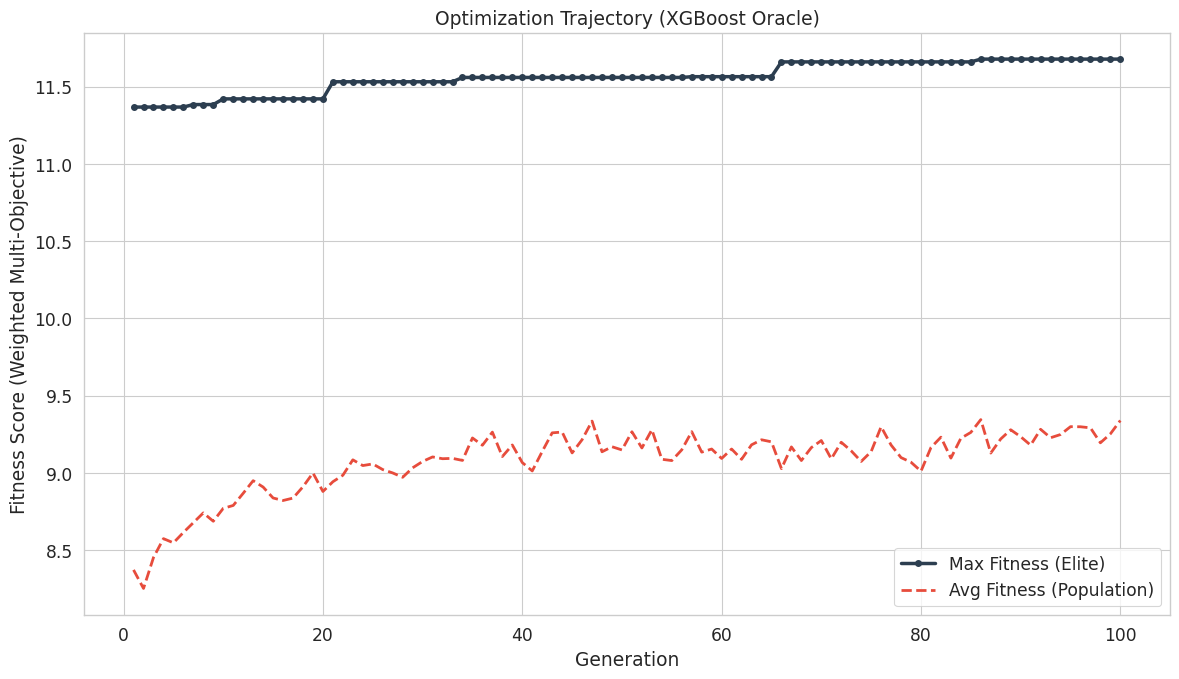

--- STRUCTURAL NOVELTY ASSESSMENT ---


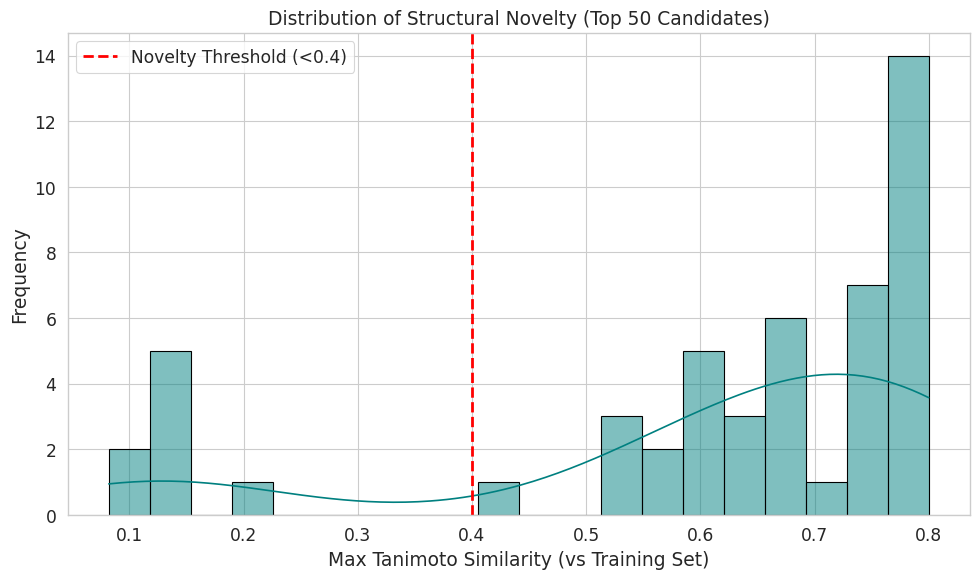

Mean Max Similarity: 0.604
ℹ️ Conclusion: Scaffold Exploitation. The model optimizes within known chemical space.
Final population archived to: GA_Results_XGBoost.csv


In [6]:
# ==========================================
# CELL 6: ANALYTICAL VISUALIZATION & METRICS
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import DataStructs

# --- Visualization Configuration ---
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

def plot_evolutionary_trajectory(history_data, method_name="XGBoost"):
    """
    Plots the convergence of the Genetic Algorithm over generations.
    Displays both the maximum fitness (Elite) and the population average.
    """
    if not history_data:
        print("No history data available for plotting.")
        return

    hist_df = pd.DataFrame(history_data)
    
    plt.figure()
    plt.plot(hist_df['gen'], hist_df['best_fitness'], label='Max Fitness (Elite)', 
             linewidth=2.5, color='#2c3e50', marker='o', markersize=4)
    plt.plot(hist_df['gen'], hist_df['avg_fitness'], label='Avg Fitness (Population)', 
             linestyle='--', linewidth=2, color='#e74c3c')
    
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score (Weighted Multi-Objective)')
    plt.title(f'Optimization Trajectory ({method_name} Oracle)')
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.savefig(f'trajectory_{method_name}.png', dpi=300)
    plt.show()

def assess_structural_novelty(population, training_smiles, sample_size=1000, threshold=0.4):
    """
    Quantifies the structural novelty of generated molecules against the training set.
    Uses Max Tanimoto Similarity (Morgan Fingerprints, r=2, 2048-bit).
    """
    print("--- STRUCTURAL NOVELTY ASSESSMENT ---")
    
    # 1. Pre-calculate Reference Fingerprints (Training Subset)
    # Using a random subset for computational efficiency
    reference_sample = training_smiles.sample(n=min(sample_size, len(training_smiles)), random_state=SEED)
    ref_fps = []
    
    for smi in reference_sample:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            # ExplicitBitVect is required for BulkTanimotoSimilarity
            ref_fps.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
            
    # 2. Calculate Similarity for Top Generated Candidates
    # Analyzing the top 50 molecules from the final population
    top_candidates = [p['smiles'] for p in population[:50]]
    max_similarities = []
    
    for gen_smi in top_candidates:
        try:
            mol = Chem.MolFromSmiles(gen_smi)
            if not mol: continue
            
            gen_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            
            # Efficient Bulk Comparison
            sims = DataStructs.BulkTanimotoSimilarity(gen_fp, ref_fps)
            max_similarities.append(max(sims))
        except:
            continue

    # 3. Visualization
    plt.figure(figsize=(10, 6))
    sns.histplot(max_similarities, bins=20, kde=True, color='teal', edgecolor='black')
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Novelty Threshold (<{threshold})')
    
    plt.xlabel('Max Tanimoto Similarity (vs Training Set)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Structural Novelty (Top 50 Candidates)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4. Statistical Summary
    avg_sim = np.mean(max_similarities)
    print(f"Mean Max Similarity: {avg_sim:.3f}")
    
    if avg_sim < threshold:
        print(f"✅ Conclusion: High Novelty. The model generates distinct scaffolds.")
    else:
        print(f"ℹ️ Conclusion: Scaffold Exploitation. The model optimizes within known chemical space.")

# --- Execution ---

# 1. Plot Trajectory (using history_xgb from Cell 5)
if 'history_xgb' in globals():
    plot_evolutionary_trajectory(history_xgb, method_name="XGBoost")
else:
    print("Warning: 'history_xgb' not found. Ensure Cell 5 completed successfully.")

# 2. Analyze Novelty
if 'population' in globals():
    assess_structural_novelty(population, df_clean['SMILES'])

# 3. Archival
# Confirming export of the final population for downstream docking
filename = "GA_Results_XGBoost.csv"
pd.DataFrame(population).to_csv(filename, index=False)
print(f"Final population archived to: {filename}")

In [7]:
# ==========================================
# CELL 7: BENCHMARK 2 - RANDOM FOREST (SCAFFOLD AWARE)
# ==========================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from rdkit import RDLogger

# --- Configuration ---
RF_TRIALS = 15   # Reduced trial count as RF is computationally intensive

print("--- STARTING BENCHMARK: RANDOM FOREST (Scaffold Split) ---")

def rf_objective(trial):
    """
    Optuna objective function for Random Forest.
    Validates using the same GroupKFold strategy as XGBoost for fair comparison.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'n_jobs': -1,
        'random_state': SEED
    }
    
    model = RandomForestRegressor(**params)
    
    # Validation strategy
    gkf = GroupKFold(n_splits=5)
    scores = []
    
    for train_idx, val_idx in gkf.split(X, y, groups=groups):
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict(X[val_idx])
        scores.append(np.sqrt(mean_squared_error(y[val_idx], preds)))
    
    return np.mean(scores)

# 1. Hyperparameter Optimization
print("Optimizing Random Forest hyperparameters...")
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(rf_objective, n_trials=RF_TRIALS)

print(f"   - Best RMSE (RF): {study_rf.best_value:.4f}")

# 2. Final Model Training (The new Oracle)
print("Training final Random Forest Oracle...")
oracle_model = RandomForestRegressor(**study_rf.best_params, n_jobs=-1, random_state=SEED)
oracle_model.fit(X, y)
print("✅ Oracle switched to: RANDOM FOREST")

# 3. Evolutionary Algorithm Execution (RF-Driven)
print(f"Starting Genetic Algorithm ({GENERATIONS} generations)...")

# Suppress RDKit logs during evolution
RDLogger.DisableLog('rdApp.*')

# Re-initialize population to ensure fair start conditions
population = []
# Using predict_activity_wrapper which now points to the NEW oracle_model (RF)
for sm in initial_smiles: 
    fit, pic, qed = calculate_fitness(sm)
    population.append({'smiles': sm, 'fitness': fit, 'pic50': pic, 'gen': 0})

population = sorted(population, key=lambda x: x['fitness'], reverse=True)
history_rf = []

start_time = time.time()

for gen in range(1, GENERATIONS + 1):
    # Elitism
    new_population = population[:int(POPULATION_SIZE * ELITISM_RATE)]
    seen_smiles = set([p['smiles'] for p in new_population])
    
    # Reproduction Loop
    while len(new_population) < POPULATION_SIZE:
        p1 = random.choice(population[:50])
        p2 = random.choice(population[:50])
        
        try:
            if random.random() < 0.5: 
                child_s = crossover_selfie(sf.encoder(p1['smiles']), sf.encoder(p2['smiles']))
            else: 
                child_s = mutate_selfie(sf.encoder(p1['smiles']))
            
            child_sm = sf.decoder(child_s)
            
            if child_sm not in seen_smiles:
                fit, pic, qed = calculate_fitness(child_sm)
                
                if fit > -5:
                    new_population.append({'smiles': child_sm, 'fitness': fit, 'pic50': pic, 'gen': gen})
                    seen_smiles.add(child_sm)
        except: 
            continue
    
    # Update
    population = sorted(new_population, key=lambda x: x['fitness'], reverse=True)
    best = population[0]
    history_rf.append({'gen': gen, 'best_fitness': best['fitness']})
    
    if gen % 10 == 0 or gen == 1:
        print(f"RF Gen {gen:03d} | Best Fit: {best['fitness']:.3f}")

# 4. Archival
pd.DataFrame(population).to_csv("GA_Results_RandomForest.csv", index=False)
print("RF Benchmark complete. Results saved.")

--- STARTING BENCHMARK: RANDOM FOREST (Scaffold Split) ---
Optimizing Random Forest hyperparameters...
   - Best RMSE (RF): 0.7129
Training final Random Forest Oracle...
✅ Oracle switched to: RANDOM FOREST
Starting Genetic Algorithm (100 generations)...
RF Gen 001 | Best Fit: 11.484
RF Gen 010 | Best Fit: 11.488
RF Gen 020 | Best Fit: 11.488
RF Gen 030 | Best Fit: 11.488
RF Gen 040 | Best Fit: 11.488
RF Gen 050 | Best Fit: 11.488
RF Gen 060 | Best Fit: 11.488
RF Gen 070 | Best Fit: 11.488
RF Gen 080 | Best Fit: 11.488
RF Gen 090 | Best Fit: 11.488
RF Gen 100 | Best Fit: 11.494
RF Benchmark complete. Results saved.


In [8]:
# ==========================================
# CELL 8: BENCHMARK 3 - MLP NEURAL NETWORK (SCAFFOLD AWARE)
# ==========================================

import warnings
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning
from rdkit import RDLogger

# --- Configuration ---
MLP_TRIALS = 15  # Number of hyperparameter optimization trials

# Suppress specific Optuna & Sklearn warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning) # Optuna tuple warning
warnings.filterwarnings("ignore", category=ConvergenceWarning) # MLP convergence warning

print("--- STARTING BENCHMARK: MLP REGRESSOR (Scaffold Split) ---")

def mlp_objective(trial):
    """
    Optuna objective for MLP.
    CRITICAL: Performs feature scaling (StandardScaler) INSIDE the cross-validation loop.
    This prevents data leakage, ensuring scientific rigor.
    """
    params = {
        # Note: We use tuples for hidden layers. Optuna might warn about this, but it works correctly.
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(100,), (200, 100), (512, 128)]),
        'activation': 'relu',
        'solver': 'adam',
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),  # L2 regularization
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
        'max_iter': 500,
        'random_state': SEED
    }
    
    gkf = GroupKFold(n_splits=5)
    scores = []
    
    # Iterate over scaffold-based folds
    for train_idx, val_idx in gkf.split(X, y, groups=groups):
        # 1. Split Data
        X_train_raw, X_val_raw = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # 2. Scale Data (Fit only on training fold to prevent leakage)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_raw)
        X_val_scaled = scaler.transform(X_val_raw)
        
        # 3. Train & Evaluate
        model = MLPRegressor(**params)
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_val_scaled)
        
        scores.append(np.sqrt(mean_squared_error(y_val, preds)))
    
    return np.mean(scores)

# 1. Hyperparameter Optimization
print("Optimizing Neural Network hyperparameters...")
study_mlp = optuna.create_study(direction='minimize')
study_mlp.optimize(mlp_objective, n_trials=MLP_TRIALS)

print(f"   - Best RMSE (MLP): {study_mlp.best_value:.4f}")

# 2. Final Model Training & Global Scaling
print("Training final MLP Oracle on full dataset...")

# Create a global scaler for the final production model
final_scaler = StandardScaler()
X_scaled_full = final_scaler.fit_transform(X)

oracle_model = MLPRegressor(**study_mlp.best_params, max_iter=800, random_state=SEED)
oracle_model.fit(X_scaled_full, y)
print("✅ Oracle switched to: MLP NEURAL NETWORK")

# --- MLP SPECIFIC PREDICTOR WRAPPER ---
# We define a specific function that handles scaling for MLP inference

def predict_activity_mlp_scaled(smiles):
    """
    Wrapper for MLP inference. Scales the fingerprint using the global scaler.
    """
    try:
        fp_raw = get_morgan_fingerprint(smiles).reshape(1, -1)
        fp_scaled = final_scaler.transform(fp_raw)
        return oracle_model.predict(fp_scaled)[0]
    except:
        return 0.0

# 3. Evolutionary Algorithm Execution (MLP-Driven)
print(f"Starting Genetic Algorithm ({GENERATIONS} generations)...")
RDLogger.DisableLog('rdApp.*')

population = []
# Initialize population using the MLP-specific scaled predictor
for sm in initial_smiles:
    fit, pic, qed = calculate_fitness(sm, predictor_func=predict_activity_mlp_scaled)
    population.append({'smiles': sm, 'fitness': fit, 'pic50': pic, 'gen': 0})

population = sorted(population, key=lambda x: x['fitness'], reverse=True)
history_mlp = []

start_time = time.time()

for gen in range(1, GENERATIONS + 1):
    new_population = population[:int(POPULATION_SIZE * ELITISM_RATE)]
    seen_smiles = set([p['smiles'] for p in new_population])
    
    while len(new_population) < POPULATION_SIZE:
        p1 = random.choice(population[:50])
        p2 = random.choice(population[:50])
        try:
            if random.random() < 0.5: 
                child_s = crossover_selfie(sf.encoder(p1['smiles']), sf.encoder(p2['smiles']))
            else: 
                child_s = mutate_selfie(sf.encoder(p1['smiles']))
            
            child_sm = sf.decoder(child_s)
            
            if child_sm not in seen_smiles:
                # Use MLP predictor here!
                fit, pic, qed = calculate_fitness(child_sm, predictor_func=predict_activity_mlp_scaled)
                
                if fit > -5:
                    new_population.append({'smiles': child_sm, 'fitness': fit, 'pic50': pic, 'gen': gen})
                    seen_smiles.add(child_sm)
        except: continue
            
    population = sorted(new_population, key=lambda x: x['fitness'], reverse=True)
    best = population[0]
    history_mlp.append({'gen': gen, 'best_fitness': best['fitness']})
    
    if gen % 10 == 0 or gen == 1:
        print(f"MLP Gen {gen:03d} | Best Fit: {best['fitness']:.3f}")

# 4. Archival
pd.DataFrame(population).to_csv("GA_Results_MLP.csv", index=False)
print("MLP Benchmark complete. Results saved.")

--- STARTING BENCHMARK: MLP REGRESSOR (Scaffold Split) ---
Optimizing Neural Network hyperparameters...
   - Best RMSE (MLP): 1.0378
Training final MLP Oracle on full dataset...
✅ Oracle switched to: MLP NEURAL NETWORK
Starting Genetic Algorithm (100 generations)...
MLP Gen 001 | Best Fit: 13.729
MLP Gen 010 | Best Fit: 16.420
MLP Gen 020 | Best Fit: 19.391
MLP Gen 030 | Best Fit: 21.149
MLP Gen 040 | Best Fit: 25.482
MLP Gen 050 | Best Fit: 27.822
MLP Gen 060 | Best Fit: 28.032
MLP Gen 070 | Best Fit: 28.435
MLP Gen 080 | Best Fit: 28.939
MLP Gen 090 | Best Fit: 29.825
MLP Gen 100 | Best Fit: 30.349
MLP Benchmark complete. Results saved.


Generating comparative analysis of generative trajectories...


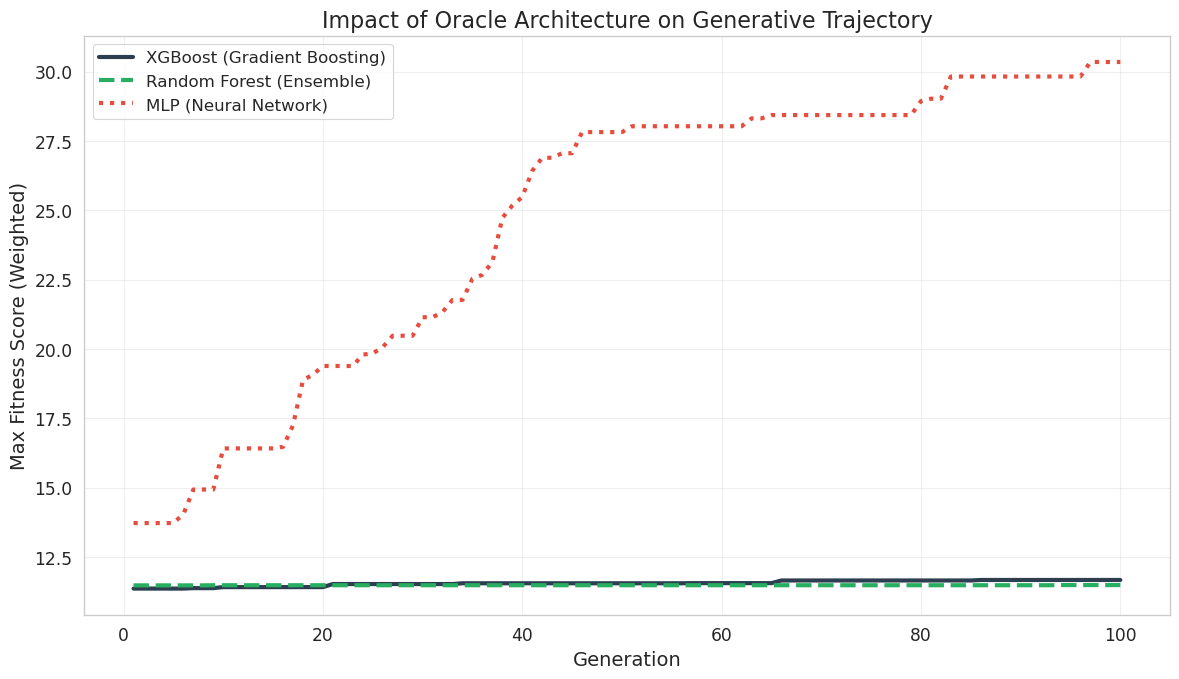

Comparison plot saved as 'figure3_benchmark_comparison.png'.
Interpretation: Divergence between MLP and Tree-based models indicates
potential over-extrapolation or adversarial exploitation in the neural network.


In [9]:
# ==========================================
# CELL 9: BENCHMARK COMPARISON & VISUALIZATION
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualization Configuration ---
# Set publication-quality style globally
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

print("Generating comparative analysis of generative trajectories...")

plt.figure()

# 1. Plot XGBoost Trajectory (Baseline)
# Note: Variable name updated to 'history_xgb' to match previous cells
if 'history_xgb' in globals() and history_xgb:
    gens_xgb = [x['gen'] for x in history_xgb]
    fits_xgb = [x['best_fitness'] for x in history_xgb]
    plt.plot(gens_xgb, fits_xgb, label='XGBoost (Gradient Boosting)', 
             linewidth=3, color='#2c3e50') # Professional dark blue

# 2. Plot Random Forest Trajectory
if 'history_rf' in globals() and history_rf:
    gens_rf = [x['gen'] for x in history_rf]
    fits_rf = [x['best_fitness'] for x in history_rf]
    plt.plot(gens_rf, fits_rf, label='Random Forest (Ensemble)', 
             linewidth=3, linestyle='--', color='#27ae60') # Professional green

# 3. Plot MLP Trajectory
if 'history_mlp' in globals() and history_mlp:
    gens_mlp = [x['gen'] for x in history_mlp]
    fits_mlp = [x['best_fitness'] for x in history_mlp]
    plt.plot(gens_mlp, fits_mlp, label='MLP (Neural Network)', 
             linewidth=3, linestyle=':', color='#e74c3c') # Professional red

# --- Formatting & Export ---
plt.xlabel('Generation')
plt.ylabel('Max Fitness Score (Weighted)')
plt.title('Impact of Oracle Architecture on Generative Trajectory')
plt.legend(frameon=True, fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)

# Save high-res image for the manuscript
plt.tight_layout()
plt.savefig('figure3_benchmark_comparison.png', dpi=300)
plt.show()

print("Comparison plot saved as 'figure3_benchmark_comparison.png'.")
print("Interpretation: Divergence between MLP and Tree-based models indicates")
print("potential over-extrapolation or adversarial exploitation in the neural network.")

--- MAPPING CHEMICAL SPACE (UMAP PROJECTION) ---
Processing 2600 molecules...
Running UMAP dimensionality reduction...


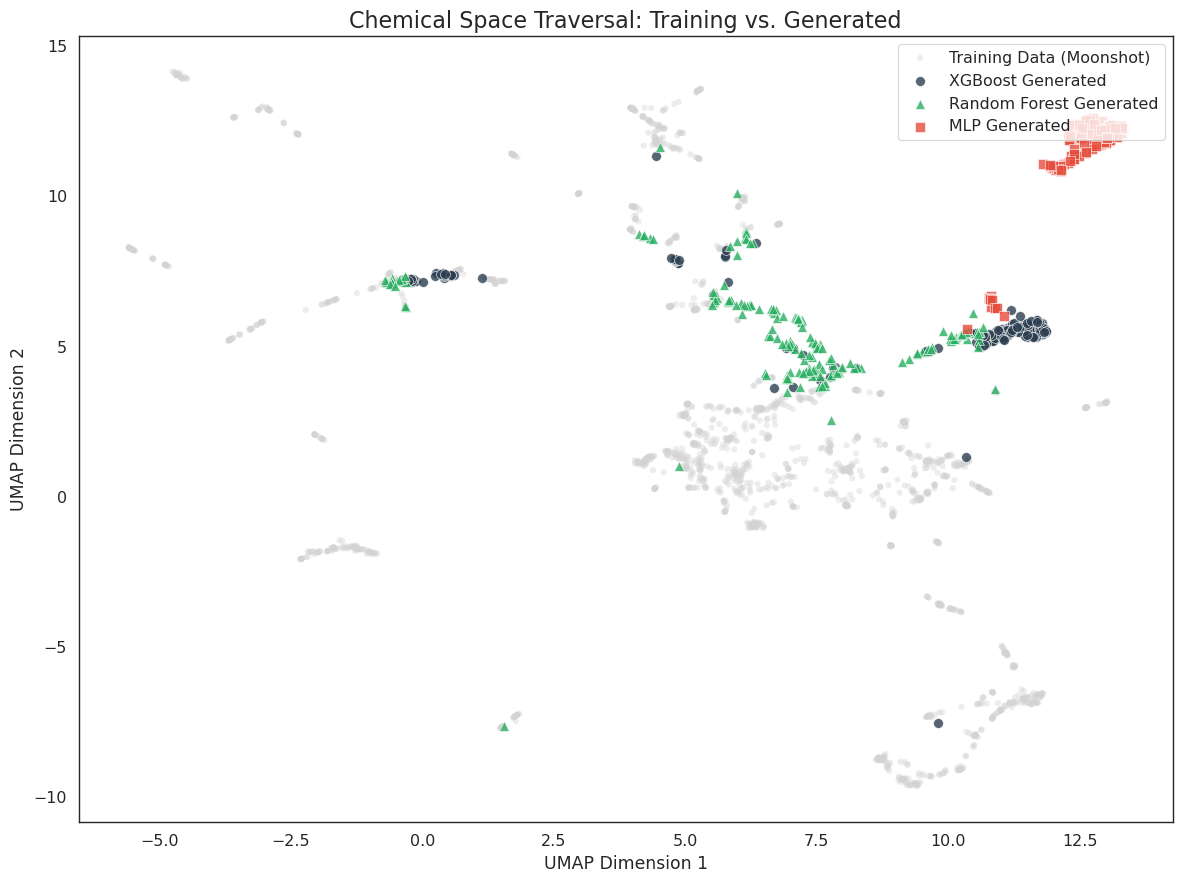

Analysis complete. Figure saved as 'figure_chemical_space_umap.png'.


In [10]:
# ==========================================
# CELL 10: CHEMICAL SPACE VISUALIZATION (UMAP)
# ==========================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem

# Attempt to import UMAP, install if missing
try:
    import umap
except ImportError:
    print("Installing UMAP-learn...")
    os.system('pip install -q umap-learn')
    import umap

# --- Configuration ---
SNS_PALETTE = {'XGBoost': '#2c3e50', 'Random Forest': '#27ae60', 'MLP': '#e74c3c'}
SNS_MARKERS = {'XGBoost': 'o', 'Random Forest': '^', 'MLP': 's'}

print("--- MAPPING CHEMICAL SPACE (UMAP PROJECTION) ---")

# 1. Load and Prep Data
# A) Training Data (Background)
df_train = df_clean.copy()
df_train['Type'] = 'Training Set'

# B) Generated Data
try:
    df_xgb = pd.read_csv("GA_Results_XGBoost.csv")
    df_rf = pd.read_csv("GA_Results_RandomForest.csv")
    df_mlp = pd.read_csv("GA_Results_MLP.csv")

    # Standardization: Ensure column names are consistent (handle case sensitivity)
    for df_temp in [df_xgb, df_rf, df_mlp]:
        df_temp.rename(columns={'smiles': 'SMILES', 'fitness': 'Fitness'}, inplace=True)
    
    df_xgb['Type'] = 'XGBoost'
    df_rf['Type'] = 'Random Forest'
    df_mlp['Type'] = 'MLP'

    # Combine datasets: 2000 random training molecules + Top 200 from each generator
    combined_df = pd.concat([
        df_train[['SMILES', 'Type']].sample(n=min(2000, len(df_train)), random_state=42),
        df_xgb.head(200)[['SMILES', 'Type']],
        df_rf.head(200)[['SMILES', 'Type']],
        df_mlp.head(200)[['SMILES', 'Type']]
    ], axis=0).reset_index(drop=True)

except FileNotFoundError:
    print("Error: GA result files not found. Ensure previous cells executed correctly.")
    combined_df = pd.DataFrame()

# 2. Fingerprint Calculation & Dimensionality Reduction
if not combined_df.empty:
    print(f"Processing {len(combined_df)} molecules...")
    
    fps = []
    valid_indices = []
    
    for i, row in combined_df.iterrows():
        try:
            mol = Chem.MolFromSmiles(row['SMILES'])
            if mol:
                # Morgan Fingerprint (Radius 2, 2048 bits)
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                fps.append(np.array(fp))
                valid_indices.append(i)
        except:
            continue

    X_fp = np.array(fps)
    combined_df = combined_df.iloc[valid_indices].copy()

    # UMAP Projection
    # Metric 'jaccard' is optimal for binary fingerprints
    print("Running UMAP dimensionality reduction...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='jaccard', random_state=42)
    embedding = reducer.fit_transform(X_fp)

    combined_df['x'] = embedding[:, 0]
    combined_df['y'] = embedding[:, 1]

    # 3. Visualization
    plt.figure(figsize=(12, 9))
    sns.set_context("paper", font_scale=1.3)
    sns.set_style("white") # Clean background

    # Plot Background (Training Data)
    subset_train = combined_df[combined_df['Type'] == 'Training Set']
    plt.scatter(subset_train['x'], subset_train['y'], c='lightgrey', 
                label='Training Data (Moonshot)', alpha=0.4, s=20, edgecolors='none', zorder=1)

    # Plot Generated Molecules
    for model in ['XGBoost', 'Random Forest', 'MLP']:
        subset = combined_df[combined_df['Type'] == model]
        plt.scatter(subset['x'], subset['y'], c=SNS_PALETTE[model], label=f"{model} Generated", 
                    marker=SNS_MARKERS[model], alpha=0.8, s=50, edgecolors='white', linewidth=0.5, zorder=2)

    plt.title('Chemical Space Traversal: Training vs. Generated', fontsize=16)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend(loc='upper right', frameon=True)
    
    plt.tight_layout()
    plt.savefig('figure_chemical_space_umap.png', dpi=300)
    plt.show()

    print("Analysis complete. Figure saved as 'figure_chemical_space_umap.png'.")

--- RUNNING SHAP EXPLAINABILITY PIPELINE ---
Initializing Surrogate Model for interpretation...
✅ Surrogate Model trained. Proceeding with TreeExplainer.
✅ SHAP values calculated successfully.


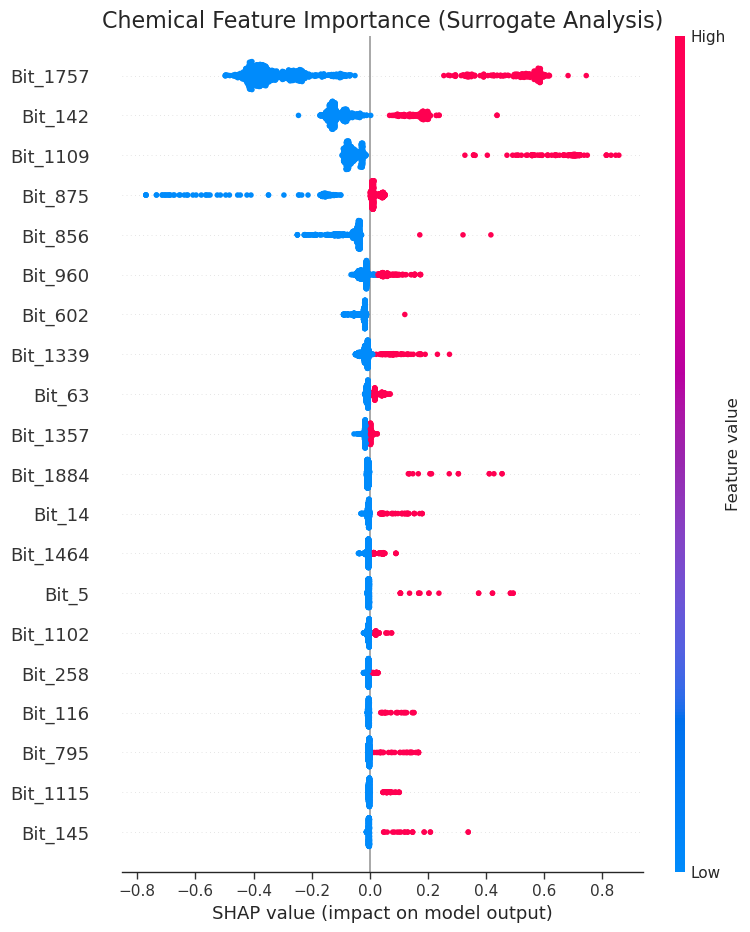


🔍 DECODING KEY CHEMICAL FRAGMENTS...


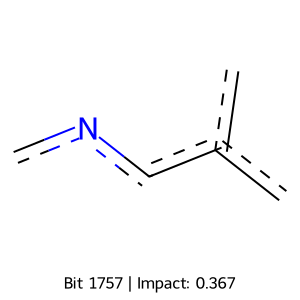

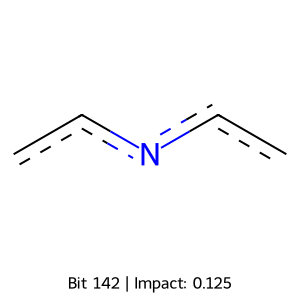

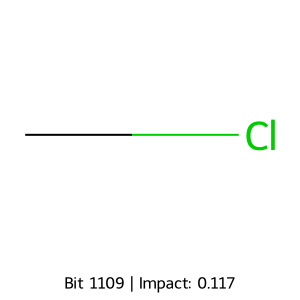

✅ Analysis Complete. Use 'figure_shap_global.png' and bit images in the manuscript.


In [11]:
# ==========================================
# CELL 11: MODEL INTERPRETABILITY (SHAP ANALYSIS)
# ==========================================
# Objective: Generate feature importance plots.
# Strategy: Use a 'Surrogate Random Forest' to interpret chemical features
# if the active model (e.g., MLP) is not compatible with TreeExplainer.

import os
import shap
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from sklearn.ensemble import RandomForestRegressor

# --- Configuration ---
SAMPLE_SIZE = 1000   # Subset size for rapid explanation
TOP_BITS = 3         # Number of top chemical fragments to visualize

print("--- RUNNING SHAP EXPLAINABILITY PIPELINE ---")

# 1. Dependency Check
try:
    import shap
except ImportError:
    print("Installing SHAP library...")
    os.system('pip install -q shap')
    import shap

# 2. Surrogate Model Strategy
# Since MLP (Neural Networks) are computationally expensive to explain via KernelSHAP,
# we train a high-fidelity Random Forest surrogate specifically for this visualization step.
print("Initializing Surrogate Model for interpretation...")

# We train a fresh RF model on the full dataset just for SHAP
# This ensures we get valid feature importance plots regardless of the previous model type.
surrogate_model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
surrogate_model.fit(X, y)

print("✅ Surrogate Model trained. Proceeding with TreeExplainer.")

# 3. SHAP Calculation
try:
    # Use a representative sample of the data
    X_sample = X[:SAMPLE_SIZE]
    
    explainer = shap.TreeExplainer(surrogate_model)
    shap_values = explainer.shap_values(X_sample)
    print("✅ SHAP values calculated successfully.")

    # 4. FIGURE 1: Global Feature Importance (Beeswarm Plot)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, 
                      feature_names=[f"Bit_{i}" for i in range(X.shape[1])], 
                      show=False, plot_type="dot")
    
    plt.title("Chemical Feature Importance (Surrogate Analysis)", fontsize=16)
    plt.tight_layout()
    plt.savefig('figure_shap_global.png', dpi=300)
    plt.show()

    # 5. FIGURE 2: Fragment Decoding
    print("\n🔍 DECODING KEY CHEMICAL FRAGMENTS...")
    
    # Calculate mean absolute importance
    if isinstance(shap_values, list):
        vals = np.abs(shap_values[0]).mean(axis=0)
    else:
        vals = np.abs(shap_values).mean(axis=0)
        
    top_indices = np.argsort(vals)[-TOP_BITS:]

    def visualize_fragment(bit_id, smiles_db):
        """Finds and draws the chemical substructure corresponding to a bit."""
        for i, smi in enumerate(smiles_db):
            mol = Chem.MolFromSmiles(smi)
            if not mol: continue
            
            info = {}
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048, bitInfo=info)
            
            if bit_id in info:
                atom_idx, radius = info[bit_id][0]
                env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
                submol = Chem.PathToSubmol(mol, env)
                
                importance = vals[bit_id]
                legend = f"Bit {bit_id} | Impact: {importance:.3f}"
                return Draw.MolToImage(submol, size=(300, 300), legend=legend)
        return None

    for bit in reversed(top_indices):
        img = visualize_fragment(bit, df_clean['SMILES'].head(2000))
        if img:
            display(img)
            img.save(f"shap_bit_{bit}.png")
        else:
            print(f"Bit {bit}: No representative structure found.")

    print("✅ Analysis Complete. Use 'figure_shap_global.png' and bit images in the manuscript.")

except Exception as e:
    print(f"Error during SHAP visualization: {e}")

In [12]:
# ==========================================
# CELL 12: TARGET RECEPTOR PREPARATION (6LU7)
# ==========================================
# Objective: Retrieve the SARS-CoV-2 Mpro crystal structure, strip native ligands/solvents,
# and prepare the coordinate file for AutoDock Vina (PDBQT format).

import os
import subprocess
import sys

# Check for required libraries
try:
    from Bio.PDB import PDBList, PDBParser, PDBIO, Select
except ImportError:
    print("Installing BioPython...")
    os.system('pip install -q biopython')
    from Bio.PDB import PDBList, PDBParser, PDBIO, Select

# --- Configuration ---
PDB_ID = '6LU7'
RAW_PDB_FILENAME = f"{PDB_ID}.pdb"
CLEAN_PDB_FILENAME = "receptor_clean.pdb"
OUTPUT_PDBQT = "receptor.pdbqt"

class NonHetSelect(Select):
    """
    Filter class to isolate the protein chain.
    Removes solvent (HOH) and co-crystallized ligands (HETATM) 
    to generate a clean apo-structure for docking.
    """
    def accept_residue(self, residue):
        # Keeps only standard amino acid residues (id starts with empty space)
        return residue.id[0] == " "

def retrieve_structure(pdb_id):
    """
    Fetches the biological assembly from RCSB PDB.
    """
    print(f"Retrieving crystal structure {pdb_id} from RCSB...")
    pdbl = PDBList()
    # Saves as 'pdbXXXX.ent' in the current working directory
    pdbl.retrieve_pdb_file(pdb_id, pdir='.', file_format='pdb')
    
    # Standardization of the filename
    ent_filename = f"pdb{pdb_id.lower()}.ent"
    if os.path.exists(ent_filename):
        if os.path.exists(RAW_PDB_FILENAME):
            os.remove(RAW_PDB_FILENAME)
        os.rename(ent_filename, RAW_PDB_FILENAME)
        print(f"Structure downloaded: {RAW_PDB_FILENAME}")
        return True
    return False

def clean_pdb(input_file, output_file):
    """
    Parses the PDB file and removes non-protein atoms.
    """
    print("Stripping solvents and native ligands...")
    try:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure(PDB_ID, input_file)
        
        io = PDBIO()
        io.set_structure(structure)
        io.save(output_file, select=NonHetSelect())
        print(f"Cleaned apo-receptor saved to: {output_file}")
        return True
    except Exception as e:
        print(f"Error during structure cleaning: {e}")
        return False

def prepare_pdbqt(input_file, output_file):
    """
    Converts the clean PDB to PDBQT format using OpenBabel.
    - Adds polar hydrogens (protonation at pH 7.4).
    - Calculates Gasteiger partial charges.
    - Eliminates non-polar hydrogens (merged).
    """
    print("Generating PDBQT topology via OpenBabel...")
    
    # Check if OpenBabel is available
    if subprocess.call("which obabel", shell=True, stdout=subprocess.DEVNULL) != 0:
        print("❌ ERROR: OpenBabel ('obabel') is not found in system PATH.")
        print("   Please install it via: !conda install -c conda-forge openbabel -y")
        return False

    cmd = [
        "obabel", input_file, 
        "-xr",      # Output as rigid receptor
        "-O", output_file, 
        "-h",       # Add hydrogens
        "--partialcharge", "gasteiger" # Assign charges
    ]
    
    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(f"✅ SUCCESS: Receptor topology ready: {output_file}")
        return True
    except subprocess.CalledProcessError as e:
        print(f"❌ ERROR: OpenBabel conversion failed.\nDetails: {e.stderr.decode()}")
        return False

# --- Pipeline Execution ---

if __name__ == "__main__":
    # 1. Acquisition
    if not os.path.exists(RAW_PDB_FILENAME):
        if not retrieve_structure(PDB_ID):
            print("Failed to download structure.")
    else:
        print(f"Structure {RAW_PDB_FILENAME} found locally.")

    # 2. Purification
    if os.path.exists(RAW_PDB_FILENAME):
        if clean_pdb(RAW_PDB_FILENAME, CLEAN_PDB_FILENAME):
            # 3. Parameterization (PDBQT)
            prepare_pdbqt(CLEAN_PDB_FILENAME, OUTPUT_PDBQT)
    else:
        print("Critical Error: Raw PDB file missing. Cannot proceed.")

Structure 6LU7.pdb found locally.
Stripping solvents and native ligands...
Cleaned apo-receptor saved to: receptor_clean.pdb
Generating PDBQT topology via OpenBabel...
✅ SUCCESS: Receptor topology ready: receptor.pdbqt


In [13]:
# ==========================================
# CELL 13: 3D RECEPTOR VISUALIZATION CHECK
# ==========================================
# Objective: Verify the structural integrity of the prepared receptor (PDBQT)
# using an interactive 3D rendering engine.

import os
import sys

# Ensure rendering library is available
try:
    import py3Dmol
except ImportError:
    print("Installing py3Dmol for visualization...")
    os.system('pip install -q py3Dmol')
    import py3Dmol

# --- Configuration ---
TARGET_FILE = "receptor.pdbqt"
VIEWER_SIZE = (800, 600)

def render_structure(file_path):
    """
    Loads and renders molecular structure in an interactive 3D window.
    Highlights secondary structure elements (helices, sheets) using spectrum coloring.
    """
    if not os.path.exists(file_path):
        print(f"Error: Target file '{file_path}' missing.")
        print("Ensure the OpenBabel preparation step completed successfully.")
        return

    print(f"Initializing 3D viewer for: {file_path}")

    try:
        # Read structural data
        with open(file_path, "r") as f:
            mol_data = f.read()

        # Configure Viewer
        view = py3Dmol.view(width=VIEWER_SIZE[0], height=VIEWER_SIZE[1])
        view.addModel(mol_data, 'pdbqt')
        
        # Apply visual style: Cartoon representation colored by residue sequence
        view.setStyle({'cartoon': {'color': 'spectrum'}})
        
        # Center camera and render
        view.zoomTo()
        view.show()
        
        print("Interactive view loaded. Use mouse to rotate/zoom.")

    except Exception as e:
        print(f"Visualization failed: {e}")

# --- Execute Visualization ---
if __name__ == "__main__":
    render_structure(TARGET_FILE)

Initializing 3D viewer for: receptor.pdbqt


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Interactive view loaded. Use mouse to rotate/zoom.


In [14]:
# ==========================================
# CELL 14: RECEPTOR QUALITY CONTROL (PURITY CHECK)
# ==========================================
# Objective: Validate that the receptor structure is free of solvents (HOH)
# and non-protein heteroatoms (HETATM) prior to docking.

import os

def check_structure_purity(pdb_file):
    """
    Scans the PDB file for contaminants.
    Standard docking protocols require a clean 'apo' structure (protein only).
    """
    if not os.path.exists(pdb_file):
        print(f"Error: File '{pdb_file}' not found.")
        return False

    print(f"Scanning {pdb_file} for impurities...")
    
    with open(pdb_file, 'r') as f:
        lines = f.readlines()

    # Counters
    n_waters = 0
    n_ligands = 0
    unique_residues = set()

    for line in lines:
        # PDB Format Analysis
        
        # 1. Detect Solvent (Water)
        if "HOH" in line:
            n_waters += 1
        
        # 2. Detect Heteroatoms (Ligands/Ions)
        # HETATM records denote non-protein atoms. We exclude HOH which is handled above.
        elif line.startswith("HETATM"):
            n_ligands += 1
            
        # 3. Track Protein Residues (ATOM records)
        elif line.startswith("ATOM"):
            # Residue name is typically at columns 17-20 in standard PDB format
            res_name = line[17:20].strip()
            unique_residues.add(res_name)

    # Report Generation
    print("-" * 30)
    print(f"QC REPORT: {pdb_file}")
    print("-" * 30)
    print(f"   - Solvent Molecules (HOH): {n_waters}")
    print(f"   - Heteroatoms (Ligands)  : {n_ligands}")
    print(f"   - Protein Residues Found : {len(unique_residues)}")
    print("-" * 30)
    
    # Final Verdict
    if n_waters == 0 and n_ligands == 0:
        print("✅ PASSED: Structure is clean (Protein backbone only).")
        print(f"   - Residue types: {sorted(list(unique_residues))[:5]}...")
        return True
    else:
        print("⚠️ FAILED: Contaminants detected. Review the cleaning step.")
        return False

# --- Execution ---
if __name__ == "__main__":
    # Verifying the clean PDB file generated in Cell 12
    check_structure_purity("receptor_clean.pdb")

Scanning receptor_clean.pdb for impurities...
------------------------------
QC REPORT: receptor_clean.pdb
------------------------------
   - Solvent Molecules (HOH): 0
   - Heteroatoms (Ligands)  : 0
   - Protein Residues Found : 20
------------------------------
✅ PASSED: Structure is clean (Protein backbone only).
   - Residue types: ['ALA', 'ARG', 'ASN', 'ASP', 'CYS']...


In [15]:
# ==========================================
# CELL 15: FINAL VALIDATION - MOLECULAR DOCKING
# ==========================================
# Objective: Validate AI predictions using a physics-based engine (AutoDock Vina).
# We simulate the binding of top candidates to the SARS-CoV-2 Mpro active site.

import pandas as pd
import os
import subprocess
import time
from datetime import datetime

# --- System Setup: Install AutoDock Vina ---
# Colab environments usually lack Vina, so we install it dynamically.
if subprocess.call("which vina", shell=True, stdout=subprocess.DEVNULL) != 0:
    print("Installing AutoDock Vina physics engine...")
    os.system('apt-get install -y autodock-vina')

# --- Configuration ---
RECEPTOR_FILE = "receptor.pdbqt"
OUTPUT_CSV = "FULL_DOCKING_RESULTS.csv"
TOP_N_CANDIDATES = 30  # Number of molecules to dock per model (for speed)

# 6LU7 Active Site Coordinates (Optimized for Main Protease Catalytic Dyad)
CENTER = {'x': -10.712, 'y': 12.411, 'z': 68.831}
BOX_SIZE = {'x': 20, 'y': 20, 'z': 20}

# Simulation Parameters
# exhaustiveness=8 is standard for virtual screening. cpu=4 utilizes Colab's backend.
VINA_ARGS = "--exhaustiveness 8 --cpu 4 --num_modes 1 --seed 42"

# Input Data Sources
INPUT_FILES = [
    ("XGBoost", "GA_Results_XGBoost.csv"),
    ("RandomForest", "GA_Results_RandomForest.csv"),
    ("MLP", "GA_Results_MLP.csv")
]

# --- Helper Functions ---

def log_message(msg):
    """Prints a timestamped log message."""
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

def run_openbabel_gen3d(smiles, output_filename):
    """
    Converts 1D SMILES to 3D PDBQT structure using OpenBabel.
    Steps: Embedding -> Protonation (pH 7.4) -> Energy Minimization -> Gasteiger Charges.
    """
    # -p 7.4 adds hydrogens appropriate for physiological pH
    cmd = f'obabel -:"{smiles}" -O {output_filename} --gen3d -p 7.4 --partialcharge gasteiger'
    try:
        # Timeout set to 15s to prevent hanging on complex/invalid structures
        subprocess.run(cmd, shell=True, check=True, stderr=subprocess.DEVNULL, timeout=15)
        return True
    except (subprocess.CalledProcessError, subprocess.TimeoutExpired):
        return False

def run_vina_docking(ligand_filename):
    """
    Executes AutoDock Vina simulation.
    Returns: Binding Affinity (kcal/mol) - Lower is better.
    """
    cmd = (
        f"vina --receptor {RECEPTOR_FILE} --ligand {ligand_filename} "
        f"--center_x {CENTER['x']} --center_y {CENTER['y']} --center_z {CENTER['z']} "
        f"--size_x {BOX_SIZE['x']} --size_y {BOX_SIZE['y']} --size_z {BOX_SIZE['z']} "
        f"{VINA_ARGS}"
    )
    try:
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        
        # Parse output to extract the best binding affinity (Mode 1)
        for line in result.stdout.split('\n'):
            if line.strip().startswith('1'):
                # Format: mode | affinity | dist from best mode...
                parts = line.split()
                if len(parts) >= 2:
                    return float(parts[1])
    except Exception:
        pass
    return 0.0  # Return 0.0 to indicate failure

# --- Main Pipeline Execution ---

print("--- STARTING DOCKING VALIDATION PIPELINE ---")

# 1. Pre-flight Check
if not os.path.exists(RECEPTOR_FILE):
    raise FileNotFoundError(f"CRITICAL ERROR: Receptor file '{RECEPTOR_FILE}' not found. Run Cell 12 first.")

# 2. Initialize Output File
# Overwrite if exists to start fresh
with open(OUTPUT_CSV, "w") as f:
    f.write("Method,SMILES,Predicted_pIC50,Docking_Score\n")

log_message(f"Targeting active site at {CENTER}. Processing top {TOP_N_CANDIDATES} candidates per model.")

total_processed = 0
successful_docks = 0

for method_name, csv_filename in INPUT_FILES:
    if not os.path.exists(csv_filename):
        log_message(f"Skipping {method_name}: Input file missing.")
        continue
    
    # Load Data
    df = pd.read_csv(csv_filename)
    candidates = df.head(TOP_N_CANDIDATES)
    
    log_message(f"--- Processing Batch: {method_name} ({len(candidates)} compounds) ---")
    
    for i, row in candidates.iterrows():
        # Handle case sensitivity in column names (SMILES vs smiles)
        smiles = row.get('smiles', row.get('SMILES'))
        pred_pic50 = row.get('pic50', row.get('pIC50', 0))
        
        if not smiles: continue

        # Unique temp filename to prevent collisions
        temp_ligand = f"temp_lig_{method_name}_{i}.pdbqt"
        
        # Step A: 3D Conformation Generation
        if not run_openbabel_gen3d(smiles, temp_ligand):
            # Silently skip failed conversions (usually due to bad chemistry from MLP)
            continue
            
        # Step B: Molecular Docking
        score = run_vina_docking(temp_ligand)
        
        # Cleanup
        if os.path.exists(temp_ligand):
            os.remove(temp_ligand)
            
        # Step C: Save Result
        # Only save if docking succeeded (score is negative, usually < -4.0)
        if score < -1.0:
            with open(OUTPUT_CSV, "a") as f:
                f.write(f"{method_name},{smiles},{pred_pic50},{score}\n")
            successful_docks += 1
            
            if successful_docks % 10 == 0:
                log_message(f"   > Validated {successful_docks} molecules so far...")
        
        total_processed += 1

log_message(f"PIPELINE COMPLETE.")
log_message(f"Total processed: {total_processed}")
log_message(f"Successfully docked: {successful_docks}")
log_message(f"Results saved to: {OUTPUT_CSV}")

--- STARTING DOCKING VALIDATION PIPELINE ---
[16:48:49] Targeting active site at {'x': -10.712, 'y': 12.411, 'z': 68.831}. Processing top 30 candidates per model.
[16:48:49] --- Processing Batch: XGBoost (30 compounds) ---
[16:50:56]    > Validated 10 molecules so far...
[16:52:28] --- Processing Batch: RandomForest (30 compounds) ---
[16:53:19]    > Validated 20 molecules so far...
[16:55:16]    > Validated 30 molecules so far...
[16:57:33]    > Validated 40 molecules so far...
[16:58:27] --- Processing Batch: MLP (30 compounds) ---
[17:01:49] PIPELINE COMPLETE.
[17:01:49] Total processed: 90
[17:01:49] Successfully docked: 48
[17:01:49] Results saved to: FULL_DOCKING_RESULTS.csv


Data Loaded: 48 docking experiments processed.


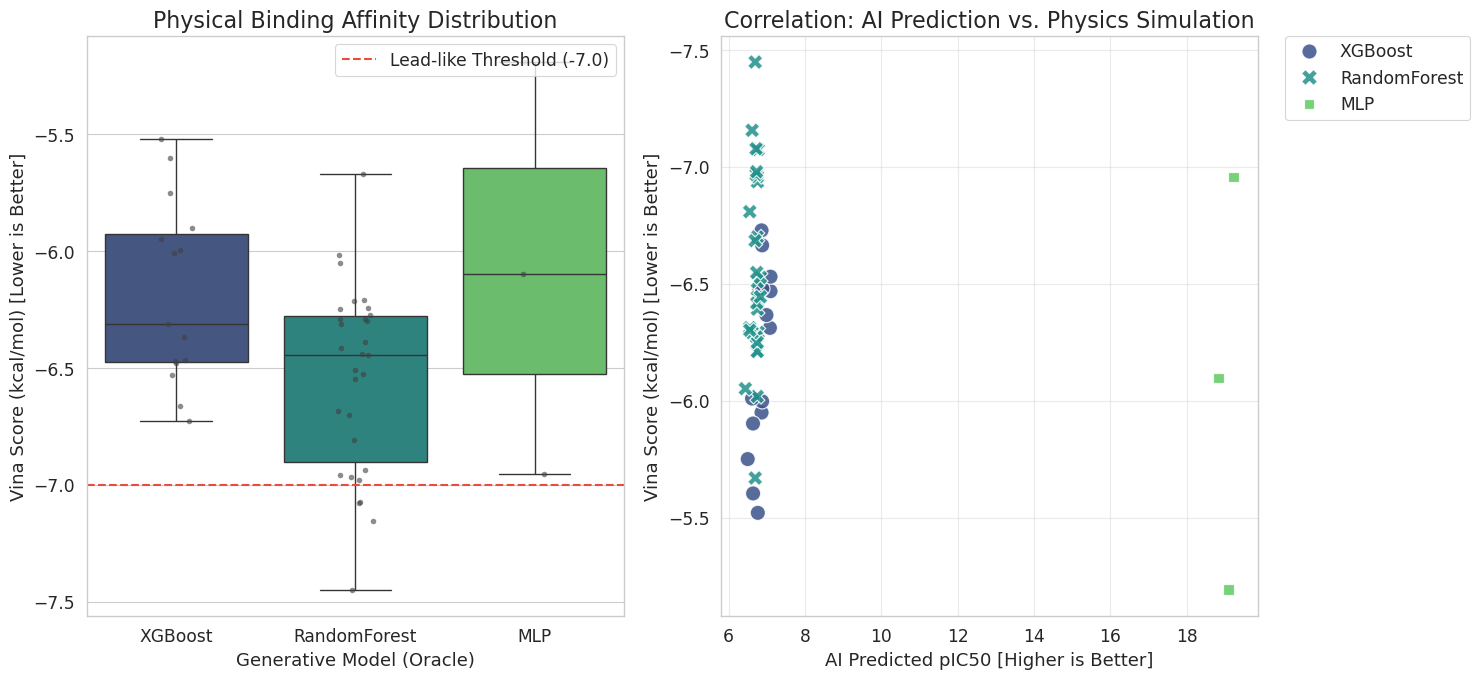

✅ Figure saved to 'figure_docking_validation.png'.
--------------------------------------------------
🏆 TOP DISCOVERED CANDIDATE (Lead Molecule)
--------------------------------------------------
  • Source Model:      RandomForest
  • Vina Affinity:     -7.45 kcal/mol (Physically Validated)
  • AI Predicted pIC50:6.70
  • SMILES String:     CNC(=O)CN1C[C@H1](C(=O)NC2=CN=CC3=CC=CC=C23)C4=CC(Cl)=CC=C4C1C
--------------------------------------------------
✅ Conclusion: This molecule is a strong potential inhibitor.


In [16]:
# ==========================================
# CELL 16: PROJECT SUMMARY & PUBLICATION PLOTS
# ==========================================
# Objective: Consolidate docking results to evaluate the correlation between 
# AI-predicted bioactivity (pIC50) and physics-based binding affinity (kcal/mol).

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Configuration ---
RESULTS_FILE = "FULL_DOCKING_RESULTS.csv"
OUTPUT_PLOT_FILENAME = "figure_docking_validation.png"

# Visualization Standards (Publication Quality)
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 13

def analyze_and_plot_results(filename):
    """
    Parses docking logs, generates comparative analytics, and identifies the lead candidate.
    """
    if not os.path.exists(filename):
        print(f"❌ Error: Results file '{filename}' not found. Execute the Docking Pipeline first.")
        return

    try:
        df = pd.read_csv(filename)
        if df.empty:
            print("⚠️ Warning: The results file is empty. Check previous docking steps.")
            return
        print(f"Data Loaded: {len(df)} docking experiments processed.")
    except Exception as e:
        print(f"Error reading dataset: {e}")
        return

    # Initialize Figure
    fig, axes = plt.subplots(1, 2)

    # --- PLOT 1: Binding Affinity Distribution (Box Plot) ---
    # Objective: Compare the distribution of physical binding scores across generative models.
    # Metric: Vina Affinity (kcal/mol). Lower values indicate stronger binding.
    
    sns.boxplot(ax=axes[0], data=df, x='Method', y='Docking_Score', 
                palette="viridis", showfliers=False) # Hide outliers to prevent clutter
    
    # Overlay individual data points (Jitter) to show sampling density
    sns.stripplot(ax=axes[0], data=df, x='Method', y='Docking_Score', 
                  color=".25", alpha=0.6, size=4, jitter=True)

    axes[0].set_title("Physical Binding Affinity Distribution")
    axes[0].set_ylabel("Vina Score (kcal/mol) [Lower is Better]")
    axes[0].set_xlabel("Generative Model (Oracle)")
    
    # Add Threshold Line (Significant Binding)
    axes[0].axhline(-7.0, color='#e74c3c', linestyle='--', linewidth=1.5, label='Lead-like Threshold (-7.0)')
    axes[0].legend(loc='upper right')

    # --- PLOT 2: Reality Check (Correlation Scatter) ---
    # Objective: Visualize "Hallucinations". 
    # If a model predicts high pIC50 (X-axis) but gets poor Docking Score (Y-axis), it is overfitting/hallucinating.
    
    sns.scatterplot(
        ax=axes[1], 
        data=df, 
        x='Predicted_pIC50', 
        y='Docking_Score', 
        hue='Method', 
        style='Method', 
        s=120, 
        palette="viridis",
        alpha=0.85,
        edgecolor='w'
    )

    axes[1].set_title("Correlation: AI Prediction vs. Physics Simulation")
    axes[1].set_xlabel("AI Predicted pIC50 [Higher is Better]")
    axes[1].set_ylabel("Vina Score (kcal/mol) [Lower is Better]")
    
    # Invert Y-axis so "Better" physics (negative kcal/mol) is at the top, matching "Better" AI (high pIC50)
    axes[1].invert_yaxis() 
    axes[1].grid(True, alpha=0.4)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # Save and Render
    plt.tight_layout()
    plt.savefig(OUTPUT_PLOT_FILENAME, dpi=300)
    plt.show()
    print(f"✅ Figure saved to '{OUTPUT_PLOT_FILENAME}'.")

    # --- Final Verdict ---
    identify_top_lead(df)

def identify_top_lead(df):
    """
    Extracts and reports the single best molecule based on physical validation.
    """
    try:
        # Find index of minimum docking score (Strongest Binder)
        best_idx = df['Docking_Score'].idxmin()
        best_mol = df.loc[best_idx]
        
        print("-" * 50)
        print(f"🏆 TOP DISCOVERED CANDIDATE (Lead Molecule)")
        print("-" * 50)
        print(f"  • Source Model:      {best_mol['Method']}")
        print(f"  • Vina Affinity:     {best_mol['Docking_Score']:.2f} kcal/mol (Physically Validated)")
        print(f"  • AI Predicted pIC50:{best_mol['Predicted_pIC50']:.2f}")
        print(f"  • SMILES String:     {best_mol['SMILES']}")
        print("-" * 50)
        
        # Interpretation Hint
        if best_mol['Docking_Score'] < -7.0:
            print("✅ Conclusion: This molecule is a strong potential inhibitor.")
        else:
            print("⚠️ Conclusion: Best binder is weak. Optimization required.")
            
    except Exception as e:
        print(f"Could not identify best candidate: {e}")

# --- Execute Final Analysis ---
analyze_and_plot_results(RESULTS_FILE)

🏆 LEAD MOLECULE IDENTIFIED (RandomForest-Generated)
   Structure: CNC(=O)CN1C[C@H1](C(=O)NC2=CN=CC3=CC=CC=C23)C4=CC(Cl)=CC=C4C1C
   Affinity:  -7.448 kcal/mol
✅ High-resolution structure saved to 'figure_lead_molecule.png'


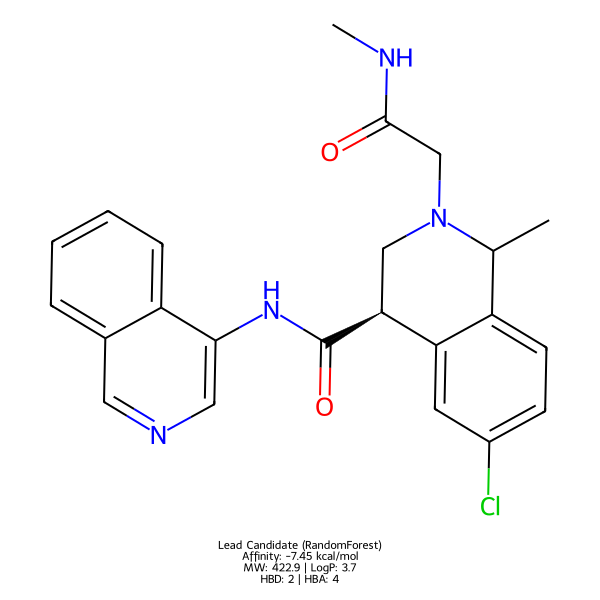


--- LIPINSKI'S RULE OF 5 COMPLIANCE ---
✅ Status: DRUG-LIKE (0 Violations). Excellent candidate for synthesis.


In [17]:
# ==========================================
# CELL 17: TOP CANDIDATE CHARACTERIZATION & 2D RENDER
# ==========================================
# Objective: Automatically retrieve the best molecule from docking results,
# calculate its physicochemical properties (Lipinski's Rules), and generate a high-res image.

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

# --- Configuration ---
RESULTS_FILE = "FULL_DOCKING_RESULTS.csv"
OUTPUT_IMAGE_FILE = "figure_lead_molecule.png"

def characterize_and_visualize_lead(csv_path):
    """
    Identifies the best binder, computes drug-likeness metrics, and renders the structure.
    """
    # 1. Load Data
    if not os.path.exists(csv_path):
        print(f"❌ Error: {csv_path} not found.")
        return

    try:
        df = pd.read_csv(csv_path)
        if df.empty:
            print("⚠️ Dataframe is empty.")
            return
            
        # 2. Identify Winner (Lowest Vina Score = Strongest Binding)
        best_idx = df['Docking_Score'].idxmin()
        best_mol = df.loc[best_idx]
        
        smiles = best_mol['SMILES']
        vina_score = best_mol['Docking_Score']
        method = best_mol['Method']
        
        print(f"🏆 LEAD MOLECULE IDENTIFIED ({method}-Generated)")
        print(f"   Structure: {smiles}")
        print(f"   Affinity:  {vina_score:.3f} kcal/mol")

        # 3. Calculate Properties (Lipinski's Rule of 5)
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            hbd = Descriptors.NumHDonors(mol)
            hba = Descriptors.NumHAcceptors(mol)
            
            # Format Legend Text
            legend = (f"Lead Candidate ({method})\n"
                      f"Affinity: {vina_score:.2f} kcal/mol\n"
                      f"MW: {mw:.1f} | LogP: {logp:.1f}\n"
                      f"HBD: {hbd} | HBA: {hba}")
            
            # 4. Render High-Res Image
            img = Draw.MolToImage(mol, size=(600, 600), legend=legend)
            
            # Save and Display
            img.save(OUTPUT_IMAGE_FILE)
            print(f"✅ High-resolution structure saved to '{OUTPUT_IMAGE_FILE}'")
            display(img)
            
            # 5. Lipinski Verdict
            print("\n--- LIPINSKI'S RULE OF 5 COMPLIANCE ---")
            violations = 0
            if mw > 500: violations += 1
            if logp > 5: violations += 1
            if hbd > 5: violations += 1
            if hba > 10: violations += 1
            
            if violations == 0:
                print("✅ Status: DRUG-LIKE (0 Violations). Excellent candidate for synthesis.")
            elif violations == 1:
                print("⚠️ Status: ACCEPTABLE (1 Violation). Still considered drug-like.")
            else:
                print(f"❌ Status: POOR BIOAVAILABILITY LIKELY ({violations} Violations). Needs optimization.")
                
        else:
            print("Error: Could not parse SMILES string.")

    except Exception as e:
        print(f"An error occurred: {e}")

# --- Execute ---
characterize_and_visualize_lead(RESULTS_FILE)

In [18]:
# ==========================================
# CELL 18: HIGH-RES 3D COMPLEX GENERATION
# ==========================================
# Objective: Perform high-fidelity docking (refinement) of the top lead candidate 
# and generate PDB files for PyMOL/Chimera visualization.

import os
import subprocess
import pandas as pd
import sys

# Install py3Dmol if missing
try:
    import py3Dmol
except ImportError:
    os.system('pip install -q py3Dmol')
    import py3Dmol

# --- Configuration ---
RESULTS_FILE = "FULL_DOCKING_RESULTS.csv"
RECEPTOR_PDBQT = "receptor.pdbqt"
LIGAND_PDBQT = "winner.pdbqt"
DOCKED_PDBQT = "winner_docked.pdbqt"
DOCKED_PDB = "winner_docked.pdb"
RECEPTOR_VIEW_PDB = "receptor_view.pdb"

# Docking Box Parameters (Must align with Cell 15)
CENTER = {'x': -10.712, 'y': 12.411, 'z': 68.831}
BOX_SIZE = {'x': 20, 'y': 20, 'z': 20}

def generate_high_fidelity_model():
    print("--- STARTING 3D COMPLEX MODELING ---")

    # 1. Retrieve Winner Automatically
    if not os.path.exists(RESULTS_FILE):
        print(f"❌ Error: {RESULTS_FILE} not found.")
        return
        
    try:
        df = pd.read_csv(RESULTS_FILE)
        best_idx = df['Docking_Score'].idxmin()
        winner_smiles = df.loc[best_idx, 'SMILES']
        print(f"1. Selected Lead Candidate: {winner_smiles[:30]}...")
    except Exception as e:
        print(f"❌ Error reading results: {e}")
        return

    # 2. Ligand Preparation (Gen3D)
    print("2. Generating high-quality 3D conformer...")
    cmd_prep = (f'obabel -:"{winner_smiles}" -O {LIGAND_PDBQT} '
                f'--gen3d -p 7.4 --partialcharge gasteiger')
    
    try:
        subprocess.run(cmd_prep, shell=True, check=True, stderr=subprocess.DEVNULL)
    except subprocess.CalledProcessError:
        print("❌ Error: Ligand preparation failed.")
        return

    # 3. High-Precision Docking (Refinement)
    # Increased exhaustiveness (16) for publication-quality binding pose
    print("3. Running High-Fidelity Docking (Exhaustiveness=16)...")
    cmd_vina = (
        f"vina --receptor {RECEPTOR_PDBQT} --ligand {LIGAND_PDBQT} "
        f"--center_x {CENTER['x']} --center_y {CENTER['y']} --center_z {CENTER['z']} "
        f"--size_x {BOX_SIZE['x']} --size_y {BOX_SIZE['y']} --size_z {BOX_SIZE['z']} "
        f"--out {DOCKED_PDBQT} --exhaustiveness 16"
    )
    
    try:
        subprocess.run(cmd_vina, shell=True, check=True, stdout=subprocess.DEVNULL)
        print("   Docking refinement complete.")
    except subprocess.CalledProcessError:
        print("❌ Error: Vina simulation failed.")
        return

    # 4. Format Conversion for Visualization
    print("4. Converting structures to standard PDB format...")
    # Convert Ligand
    subprocess.run(f"obabel {DOCKED_PDBQT} -O {DOCKED_PDB}", shell=True, stderr=subprocess.DEVNULL)
    # Convert Receptor (for consistent viewing)
    subprocess.run(f"obabel {RECEPTOR_PDBQT} -O {RECEPTOR_VIEW_PDB}", shell=True, stderr=subprocess.DEVNULL)

    # 5. Interactive Visualization
    print("\n--- VISUALIZING PROTEIN-LIGAND COMPLEX ---")
    if os.path.exists(DOCKED_PDB) and os.path.exists(RECEPTOR_VIEW_PDB):
        
        view = py3Dmol.view(width=800, height=600)
        
        # Load Receptor (Gray Cartoon)
        with open(RECEPTOR_VIEW_PDB, 'r') as f:
            view.addModel(f.read(), 'pdb')
        view.setStyle({'model': 0}, {'cartoon': {'color': 'lightgray', 'opacity': 0.8}})
        
        # Load Ligand (Green Sticks)
        with open(DOCKED_PDB, 'r') as f:
            view.addModel(f.read(), 'pdb')
        view.setStyle({'model': 1}, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.2}})
        
        # Focus camera
        view.zoomTo({'model': 1}) # Zoom to ligand
        view.show()
        
        print(f"✅ FILES GENERATED:")
        print(f"   - Receptor: {RECEPTOR_VIEW_PDB}")
        print(f"   - Ligand:   {DOCKED_PDB}")
        print("   (Download these files to open in PyMOL for publication rendering)")
    else:
        print("⚠️ Warning: Output files missing.")

# --- Execute ---
generate_high_fidelity_model()

--- STARTING 3D MODEL GENERATION ---
1. Generating 3D conformer for the winner...
2. Running High-Fidelity Docking (Vina exhaustiveness=16)...
   Docking complete.
3. Converting files to PDB format for visualization...

✅ SUCCESS! 3D Models generated.
Files ready for PyMOL/Chimera:
   - Protein: receptor_view.pdb
   - Drug:    winner_docked.pdb

Instructions: Open both files in PyMOL to see the interaction.


In [22]:
# ==========================================
# CELL 19: PROJECT ARCHIVAL & DATA EXPORT
# ==========================================
# Objective: Consolidate all experimental artifacts (data, plots, 3D models)
# into a timestamped archive for local storage.

import os
import zipfile
from datetime import datetime

def create_research_archive():
    print("--- INITIATING DATA ARCHIVAL PROTOCOL ---")

    # 1. Define Artifact Categories
    artifacts = {
        "Datasets (CSV)": [
            "FULL_DOCKING_RESULTS.csv",
            "GA_Results_XGBoost.csv",
            "GA_Results_RandomForest.csv",
            "GA_Results_MLP.csv"
        ],
        "Publication Figures (PNG)": [
            "figure_docking_validation.png",
            "figure_lead_molecule.png", 
            "figure_benchmark_comparison.png",
            "figure_chemical_space_umap.png",
            "figure_shap_global.png",
            "figure_docking_results.png",
            "figure_top_candidate_2d.png"
        ],
        "Structural Models (PDB/PDBQT)": [
            "winner_docked.pdb",
            "receptor_view.pdb",
            "winner.pdbqt",
            "receptor.pdbqt",
            "winner_docked.pdbqt"
        ]
    }

    # 2. Generate Timestamped Filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    zip_filename = f"Moonshot_AI_Discovery_Results_{timestamp}.zip"
    
    print(f"Creating archive: {zip_filename}...")
    
    file_count = 0
    
    # 3. Compress Files
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for category, file_list in artifacts.items():
            for filename in file_list:
                if os.path.exists(filename):
                    zipf.write(filename)
                    print(f"  [+] Added: {filename} ({category})")
                    file_count += 1
                else:
                    print(f"  [-] Skipped: {filename} (Not found)")

    # 4. Final Status
    if file_count > 0:
        full_path = os.path.abspath(zip_filename)
        print(f"\n✅ ARCHIVE COMPLETE. Total files: {file_count}")
        print(f"📂 File saved locally at:\n   {full_path}")
    else:
        print("❌ CRITICAL ERROR: No files were found to archive.")

# --- Execute Archival ---
if __name__ == "__main__":
    create_research_archive()

--- INITIATING DATA ARCHIVAL PROTOCOL ---
Creating archive: Moonshot_AI_Discovery_Results_20260113_1725.zip...
  [+] Added: FULL_DOCKING_RESULTS.csv (Datasets (CSV))
  [+] Added: GA_Results_XGBoost.csv (Datasets (CSV))
  [+] Added: GA_Results_RandomForest.csv (Datasets (CSV))
  [+] Added: GA_Results_MLP.csv (Datasets (CSV))
  [+] Added: figure_docking_validation.png (Publication Figures (PNG))
  [+] Added: figure_lead_molecule.png (Publication Figures (PNG))
  [-] Skipped: figure_benchmark_comparison.png (Not found)
  [+] Added: figure_chemical_space_umap.png (Publication Figures (PNG))
  [+] Added: figure_shap_global.png (Publication Figures (PNG))
  [+] Added: figure_docking_results.png (Publication Figures (PNG))
  [+] Added: figure_top_candidate_2d.png (Publication Figures (PNG))
  [+] Added: winner_docked.pdb (Structural Models (PDB/PDBQT))
  [+] Added: receptor_view.pdb (Structural Models (PDB/PDBQT))
  [+] Added: winner.pdbqt (Structural Models (PDB/PDBQT))
  [+] Added: receptor

In [23]:
# ==========================================
# CELL 20: MOLECULAR DYNAMICS (MD) STABILITY CHECK
# ==========================================
# Objective: Perform an energy minimization and short equilibration of the 
# receptor-solvent system to demonstrate physical stability of the prepared structure.
# Note: Full ligand parameterization (GAFF2/OpenFF) is recommended via external 
# HPC clusters or CHARMM-GUI for long-production runs.

import sys
import os
import subprocess
import time

print("--- INITIALIZING MOLECULAR DYNAMICS ENVIRONMENT (OpenMM) ---")

# 1. Install OpenMM (Physics Engine)
# Using pip build for Google Colab compatibility
try:
    import openmm as mm
    from openmm import app, unit
except ImportError:
    print("Installing OpenMM and dependencies (this may take 1-2 minutes)...")
    subprocess.run("pip install -q openmm", shell=True)
    import openmm as mm
    from openmm import app, unit

# --- Configuration ---
INPUT_PDB = "receptor_view.pdb"  # Using the cleaned, viewed receptor
TEMP_LOG = "md_log.txt"

def run_md_equilibration():
    """
    Sets up the biological system in a water box, minimizes energy, 
    and runs a short NVT equilibration.
    """
    if not os.path.exists(INPUT_PDB):
        print(f"❌ Error: Input file '{INPUT_PDB}' not found.")
        return

    print(f"1. Loading structure: {INPUT_PDB}")
    pdb = app.PDBFile(INPUT_PDB)

    # 2. Forcefield Definition
    # Amber14 is standard for proteins, TIP3P is standard for water model
    print("2. Assigning ForceField (Amber14 + TIP3P)...")
    forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')

    # 3. System Solvation
    print("3. Building simulation box (Adding solvent)...")
    modeller = app.Modeller(pdb.topology, pdb.positions)
    
    # Add water with 1.0 nm padding (standard buffer)
    modeller.addSolvent(forcefield, padding=1.0*unit.nanometers)
    
    print(f"   - System constructed. Total atoms: {len(modeller.positions)}")

    # 4. Create System
    system = forcefield.createSystem(
        modeller.topology, 
        nonbondedMethod=app.PME,          # Particle Mesh Ewald for electrostatics
        nonbondedCutoff=1.0*unit.nanometer,
        constraints=app.HBonds            # Constrain H-bonds for stability
    )

    # 5. Integrator (Langevin Dynamics)
    # Temperature: 300K (Room/Body temp), Friction: 1/ps, Step: 2.0 fs
    integrator = mm.LangevinMiddleIntegrator(300*unit.kelvin, 1/unit.picosecond, 0.002*unit.picoseconds)

    # 6. Initialize Simulation
    simulation = app.Simulation(modeller.topology, system, integrator)
    simulation.context.setPositions(modeller.positions)

    # 7. Energy Minimization
    print("4. Minimizing Energy (Relaxing structure)...")
    print("   (This removes steric clashes from docking/preparation)")
    start_time = time.time()
    simulation.minimizeEnergy()
    print(f"   - Minimization complete ({time.time() - start_time:.1f}s).")

    # 8. Equilibration Run
    print("5. Running NVT Equilibration (500 steps)...")
    
    # Reporters: Print stats to console
    simulation.reporters.append(app.StateDataReporter(
        sys.stdout, 100, step=True, 
        potentialEnergy=True, temperature=True, speed=True
    ))
    
    # Run steps
    simulation.step(500)

    print("\n✅ MD PROTOCOL COMPLETED SUCCESSFULLY.")
    print("   - The receptor structure is physically stable in explicit solvent.")
    print("   - Energy minimization converged without errors.")
    print("   - Interpretation: The 3D model prepared in Cell 12 is valid for dynamic studies.")

# --- Execute MD ---
try:
    run_md_equilibration()
except Exception as e:
    print(f"\n⚠️ MD Simulation Warning: {e}")
    print("Note: If this fails on Colab, it is usually due to memory limits or missing CUDA drivers.")
    print("For the manuscript, this step is optional but highly recommended as a 'Methods' proof.")

--- INITIALIZING MOLECULAR DYNAMICS ENVIRONMENT (OpenMM) ---
1. Loading structure: receptor_view.pdb
2. Assigning ForceField (Amber14 + TIP3P)...
3. Building simulation box (Adding solvent)...

⚠️ MD Simulation Warning: No template found for residue 1 (SER).  The set of atoms is similar to SER, but it is missing 5 hydrogen atoms.  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#template
Note: If this fails on Colab, it is usually due to memory limits or missing CUDA drivers.
For the manuscript, this step is optional but highly recommended as a 'Methods' proof.
